In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, plot_confusion_matrix


In [2]:
SEED = 42
CSV_LOCATION = "peace_sys.csv"

In [3]:
VARS = {'ID1.1Over' : 'Overarching Identity', 'Int2.4Hist' : 'Interconnected Historically', 
        'Int2.2Econ' : 'Interconnected Economically', 'Dep3.3Econ' : 'Interdependent Economically', 
        'Dep3.2Ecol' : 'Interdependent Ecologically', 'NWNorm5.1': 'Non-Warring Norms', 
        'NWVal4.1' : 'Non-Warring Values', 'SymP6': 'Peace Symbols', 'RitP6' : 'Peace Rituals', 
        'CM8.5Peace' : 'Peaceful Conflict Management Overall'}

In [4]:
def mode(x):
    """
    Parameters
    ----------
        x: 1D numpy array
        
    Return
    ------
        scalar representing the mode of the arr
    """
    # count number of 1 in x
    one_sum = np.count_nonzero(x == 1)
    # count number of 0 in x
    zero_sum = np.count_nonzero(x == 0)
    # return mode if a mode exists
    if one_sum > zero_sum:
        return 1

    if one_sum == zero_sum:
        return 2
    
    return 0

In [5]:
def logistic_sigmoid(x, beta, intercept):
    """
    Args: 
        x: scalar with score [1-4] for each factor for each obeservation.
        betas: scalar betas extracted from logreg model.
        intercept: number extracted from logreg model. Denoted as beta_0
    Returns:
        scalar that represent the probability
    """
    
    return 1 / (1 + np.exp(-(intercept + beta * x)))

In [6]:
def train_on_feature(X, y):
    """
    Trains logistic regression model on 1 feature.  X and y must have equal dimensions.
    
    Parameters
    ----------
    X: dataframe containing 1 column. Shape is (m, 1). m is the number of rows.
        X can contain Nan values.
    y: dataframe containing labels for each obeservation in X. 
        Same is (m, 1). m is the number of rows. 
        
    Returns
    -------
    
            
    """
    # store the freature name for reference
    feature_name = X.columns[0]
    label = 'label'
    # concatenate feature and labels into one df
    concat_df = pd.DataFrame({feature_name: list(X[feature_name]), label: y})
    # drop nan values
    concat_df = concat_df.dropna()
    # reasign values to feature df
    X = pd.DataFrame(concat_df[feature_name])
    # reasign values to label df
    y = pd.DataFrame(concat_df[label])
    # init model
    logreg = LogisticRegression(random_state=SEED)
    # train model
    logreg.fit(X, y[label].ravel())
    
    intercept = logreg.intercept_[0]
    beta = logreg.coef_[0][0]
    
    return beta, intercept


In [7]:
def generate_betas_and_intercepts(X, y):
    """
    Genearates beta, and intercept for each feature in X. 
    
    Parameters
    ---------
    X: dataframe containing all observations. Shape (m, n)
    y: dataframe containg all labels for each observaation in X. Shape (m, 1)
    
    Returns
    -------
    res: dataframe containg beta and intercepts for each feature. res columns have the pattern
        (beta, intercept)
    
    """
    # store beta and intercept for each feature
    res = pd.DataFrame()
    
    for col in X.columns:
        # get the df for col
        feature_df = pd.DataFrame(X[col])
        # get prediciton
        beta, intercept = train_on_feature(feature_df, y)
        # add to the other predictions
        res[col] = [(beta, intercept)]
        
    return res

In [63]:
def predict_with_given_betas_and_intercepts(X, betas_intercepts):
    """
    Predict a 0 or 1 value for each observation given the beta and intercept for each feature
    
    Parameters
    ---------
    X: dataframe containing all observations. Shape (m, n)
    betas_intercepts: dataframe containing one row. each cell contains a tuple described as (beta, intercept).
    
    Returns
    ------
    y_preds: array that cointains a predictions for each culture(observation). There are 42 observations
    
    """
    # get the humber of rows
    num_rows = X.shape[0]
    y_preds = []
    
    for i in range(num_rows):
        # get the current row
        curr = X.iloc[i]
        # create copy of betas_intercepts df
        beta_inter_copy = betas_intercepts
        # append the row to the copy
        concat_df = beta_inter_copy.append(curr)
        # drop columns that have missing values
        concat_df = concat_df.dropna(axis=1)
        # contains all the prediction for each observation 
        preds = []
        for col in concat_df.columns:
            # get the beta
            beta = concat_df[col].iloc[0][0] 
            # get the intercept
            intercept = concat_df[col].iloc[0][1]
            # get the observation that is an int from 1-4
            observation = concat_df[col].iloc[1]
            obs_pred = logistic_sigmoid(observation, beta, intercept)
            # append to predictions arr
            preds.append(obs_pred)
        # convert values >= 0.5 to 1, otherwise 0
        preds = list(map(lambda x: 1 if x >= 0.5 else 0, preds))
        # get the mode to give a final classification
        preds_mode = mode(np.array(preds))
        y_preds.append(preds_mode)
        
    return y_preds


In [9]:
df = pd.read_csv(CSV_LOCATION)

In [10]:
X = df[VARS.keys()].replace(9, np.nan)

In [11]:
y = df["PSysRec"]

In [66]:
# Train loop
num_rows = X.shape[0]
y_preds = [] 

for i in range(num_rows):
    # get the test culture
    X_test = X[i:i+1]
    y_test = X[i:i+1]
    
    # create train sets without single culture
    X_train = X.drop(index=i, axis=1)
    y_train = y.drop(index=i, axis=1)
    
    # get learned betas from logreg
    betas_inter = generate_betas_and_intercepts(X_train, y_train)
    
    # returns prediction for a single culture
    y_hat = predict_with_given_betas_and_intercepts(X_test, betas_inter)[0]
    y_preds.append(y_hat)


In [70]:
conf_matrix = confusion_matrix(y, y_preds)

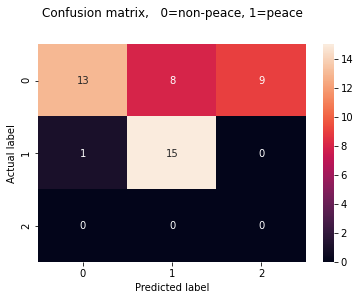

In [79]:
plt.rcParams['savefig.facecolor'] = 'white'
conf_matrix_plot = sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion matrix,   0=non-peace, 1=peace', y=1.1)

plt.ylabel('Actual label')

plt.xlabel('Predicted label')

plt.show(block=False)

In [80]:
conf_matrix_plot.get_figure().savefig('indep_keys_conf_matrix.png')

In [73]:
pred_df = pd.DataFrame(data={'Name': df.Name, 'Actual': y, 'Prediction': y_preds})

In [ ]:
pred_df.to_excel('indep_keys_preds.xlsx')